# Progetto IDS
### Nicolò Calandra - Andrea Di Blasi

## Introduzione
In questo progetto andremo a creare un modello predittivo sulla formula 1.
L'obiettivo è di analizzare la correlazione tra posizione in qualifica e posizione in gara in base al tipo di circuito, che suddivideremo in 3 categorie: circuito ad alta velocità, circuito tecnico e circuito misto.
Con circuito tecnico intendiamo una pista ricca di curve, in cui il fattore più importante è la tecnica e bravura del pilota più che il veicolo che guida. Un circuito ad alta velocità, invece, è costituito da più rettilinei in cui la tecnica e la bravura del pilota sono meno influenti sul risultato della gara, bensì la potenza del veicolo influenza la posizione finale. Un circuito misto è costituito da una combinazione di entrambe le caratteristiche.

## Caratteristiche del dataset
Come dataset utilizziamo F1DB, che contiene una grande quantità di dati dal 1950 al 2024.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Carichiamo i dati
circuits = pd.read_csv("f1db-csv/f1db-circuits.csv")
races = pd.read_csv("f1db-csv/f1db-races.csv")
results = pd.read_csv("f1db-csv/f1db-races-race-results.csv")


/var/folders/4h/1sww1ntx4bd__02c69f9yqjc0000gn/T/ipykernel_25154/976909659.py:9: DtypeWarning: Columns (31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  results = pd.read_csv("f1db-csv/f1db-races-race-results.csv")


Visualizziamo i dataset caricati per capire meglio le informazioni contenute.

In [6]:
circuits.head()

,id,name,fullName,previousNames,type,direction,placeName,countryId,latitude,longitude,length,turns,totalRacesHeld,circuitType
0,adelaide,Adelaide,Adelaide Street Circuit,NaN,STREET,CLOCKWISE,Adelaide,australia,-34.927222,138.617222,3.780,16,11,Tecnico
1,aida,Aida,Okayama International Circuit,TI Circuit Aida,RACE,CLOCKWISE,Aida,japan,34.915000,134.221111,3.703,13,2,Tecnico
2,ain-diab,Ain-Diab,Ain-Diab Circuit,NaN,ROAD,CLOCKWISE,Casablanca,morocco,33.578611,-7.687500,7.618,18,1,Misto
3,aintree,Aintree,Aintree Motor Racing Circuit,NaN,ROAD,CLOCKWISE,Aintree,united-kingdom,53.476944,-2.940556,4.828,8,5,Misto
4,anderstorp,Anderstorp Raceway,Anderstorp Raceway,Scandinavian Raceway,RACE,CLOCKWISE,Anderstorp,sweden,57.264167,13.601389,4.031,8,6,Tecnico


In [7]:
circuits.isnull().sum()

id                 0
name               0
fullName           0
previousNames     62
type               0
direction          0
placeName          0
countryId          0
latitude           0
longitude          0
length             0
turns              0
totalRacesHeld     0
circuitType        0
dtype: int64

In [8]:
races.head()

,id,year,round,date,time,grandPrixId,officialName,qualifyingFormat,sprintQualifyingFormat,circuitId,...,qualifying2Date,qualifying2Time,qualifyingDate,qualifyingTime,sprintQualifyingDate,sprintQualifyingTime,sprintRaceDate,sprintRaceTime,warmingUpDate,warmingUpTime
0,1,1950,1,1950-05-13,NaN,great-britain,1950 RAC British Grand Prix,TWO_SESSION,NaN,silverstone,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1950,2,1950-05-21,NaN,monaco,Grand Prix de Monaco 1950,TWO_SESSION,NaN,monaco,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1950,3,1950-05-30,NaN,indianapolis,1950 Indianapolis 500,FOUR_LAPS,NaN,indianapolis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1950,4,1950-06-04,NaN,switzerland,Grosser Preis der Schweiz 1950,TWO_SESSION,NaN,bremgarten,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1950,5,1950-06-18,NaN,belgium,1950 Belgian Grand Prix,TWO_SESSION,NaN,spa-francorchamps,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
races.isnull().sum()

id                                    0
year                                  0
round                                 0
date                                  0
time                               1101
grandPrixId                           0
officialName                          0
qualifyingFormat                      0
sprintQualifyingFormat             1131
circuitId                             0
circuitType                           0
direction                             0
courseLength                          0
turns                                 0
laps                                  0
distance                              0
scheduledLaps                      1071
scheduledDistance                  1071
driversChampionshipDecider            0
constructorsChampionshipDecider       0
preQualifyingDate                  1149
preQualifyingTime                  1149
freePractice1Date                  1101
freePractice1Time                  1101
freePractice2Date                  1113


In [10]:
results.head()

,raceId,year,round,positionDisplayOrder,positionNumber,positionText,driverNumber,driverId,constructorId,engineManufacturerId,...,polePosition,qualificationPositionNumber,qualificationPositionText,gridPositionNumber,gridPositionText,positionsGained,pitStops,fastestLap,driverOfTheDay,grandSlam
0,1,1950,1,1,1.0,1,2,nino-farina,alfa-romeo,alfa-romeo,...,True,1.0,1,1.0,1,0.0,NaN,True,NaN,False
1,1,1950,1,2,2.0,2,3,luigi-fagioli,alfa-romeo,alfa-romeo,...,False,2.0,2,2.0,2,0.0,NaN,False,NaN,False
2,1,1950,1,3,3.0,3,4,reg-parnell,alfa-romeo,alfa-romeo,...,False,4.0,4,4.0,4,1.0,NaN,False,NaN,False
3,1,1950,1,4,4.0,4,14,yves-giraud-cabantous,talbot-lago,talbot-lago,...,False,6.0,6,6.0,6,2.0,NaN,False,NaN,False
4,1,1950,1,5,5.0,5,15,louis-rosier,talbot-lago,talbot-lago,...,False,9.0,9,9.0,9,4.0,NaN,False,NaN,False


In [11]:
results.isnull().sum()

raceId                             0
year                               0
round                              0
positionDisplayOrder               0
positionNumber                 10815
positionText                       0
driverNumber                       0
driverId                           0
constructorId                      0
engineManufacturerId               0
tyreManufacturerId                 0
sharedCar                          0
laps                            1920
time                           19155
timeMillis                     19155
timePenalty                    26668
timePenaltyMillis              26668
gap                            12681
gapMillis                      20285
gapLaps                        19307
interval                       20303
intervalMillis                 20303
reasonRetired                  16958
points                         18689
polePosition                       0
qualificationPositionNumber      710
qualificationPositionText        582
g

A questo punto dobbiamo creare un dataframe che contenga solamente le informazioni necessarie per la visualizzazione, ovvero:
- la posizione in grid
- la posizione finale
- il tipo di circuito


In [12]:
from math import nan

# Facciamo un merge tra i risultati e le gare
races.rename(columns={'id': 'raceId'}, inplace=True)
df = pd.merge(results, races, on='raceId', how='left', validate='m:1')  

# Facciamo un merge tra i risultati e i circuiti
circuits.rename(columns={'id': 'circuitId'}, inplace=True)
df = pd.merge(df, circuits, on='circuitId', how='left', validate='m:1')

# Selezioniamo solo le colonne che ci servono
df = df[['gridPositionNumber', 'positionNumber', 'circuitType_y']]

df.rename(columns={'circuitType_y': 'tipo_circuito'}, inplace=True)
df.rename(columns={'gridPositionNumber': 'posizione_partenza'}, inplace=True)
df.rename(columns={'positionNumber': 'posizione_finale'}, inplace=True)

# Selezioniamo solo le gare in cui il pilota parte da una delle prime due righe
df = df[(df['posizione_partenza'] <= 4) & (df['posizione_partenza'] > 0)]

# Sostituiamo tutti i valori NaN (ovvero i non arrivato) con 0
df = df.replace(nan, 0)

df = df[df['posizione_finale'] < 22]
df['punti'] = df['posizione_finale'].apply(lambda x: 'Non arrivato' if x == 0 else 'Podio' if x <= 3 else 'Punti' if x <= 10 else 'No punti')


df.head()

,posizione_partenza,posizione_finale,tipo_circuito,punti
0,1.0,1.0,Alta velocità,Podio
1,2.0,2.0,Alta velocità,Podio
2,4.0,3.0,Alta velocità,Podio
12,3.0,0.0,Alta velocità,Non arrivato
23,1.0,1.0,Tecnico,Podio


Inizialmente visualizziamo i dati utilizzando degli istogrammi, che mostrano chiaramente le posizione dei piloti in base al tipo di circuito ricordando che 0 indica non arrivato.

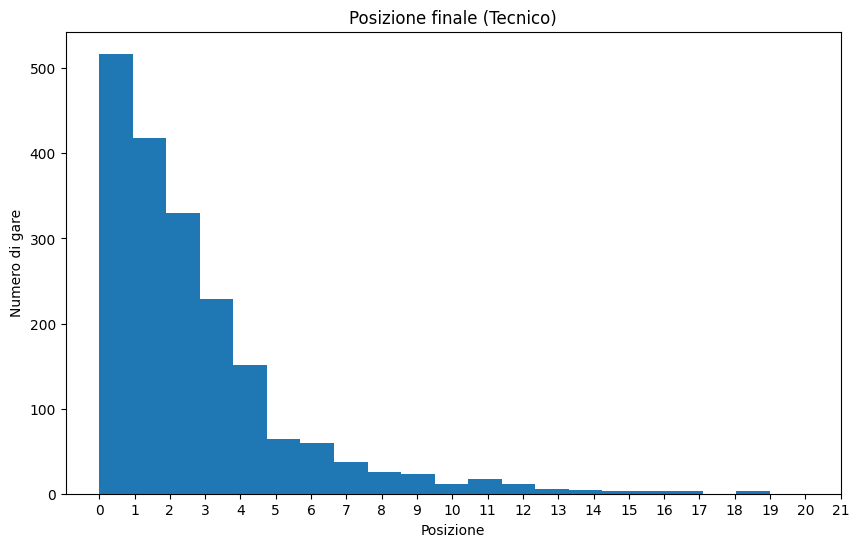

In [13]:
position_technical = df[df["tipo_circuito"] == "Tecnico"]
plt.figure(figsize=(10, 6))
plt.hist(position_technical["posizione_finale"].astype(int), bins=20)
plt.xlabel("Posizione") 
plt.ylabel("Numero di gare")
plt.title("Posizione finale (Tecnico)")
plt.xticks(range(0, 22))
plt.show()


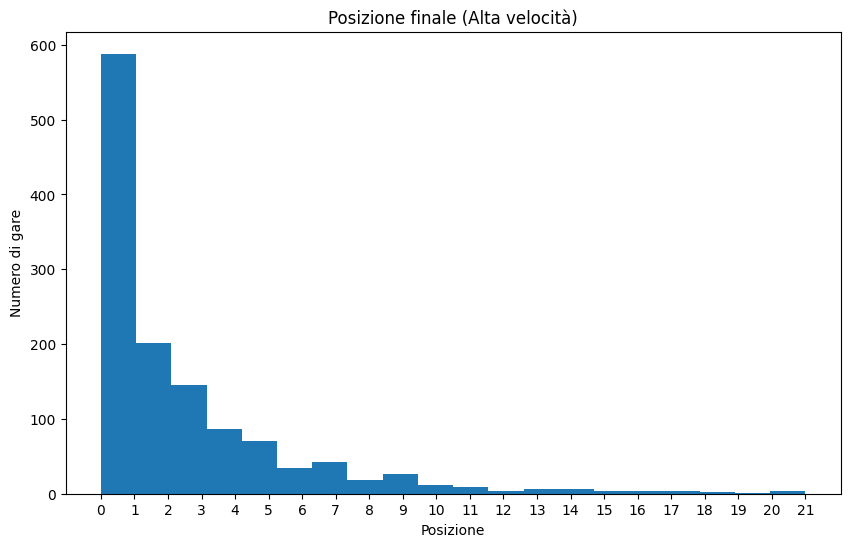

In [14]:
position_highspeed = df[df["tipo_circuito"] == "Alta velocità"]
plt.figure(figsize=(10, 6))
plt.hist(position_highspeed["posizione_finale"].astype(int), bins=20)
plt.xlabel("Posizione") 
plt.ylabel("Numero di gare")
plt.title("Posizione finale (Alta velocità)")
plt.xticks(range(0, 22))
plt.show()

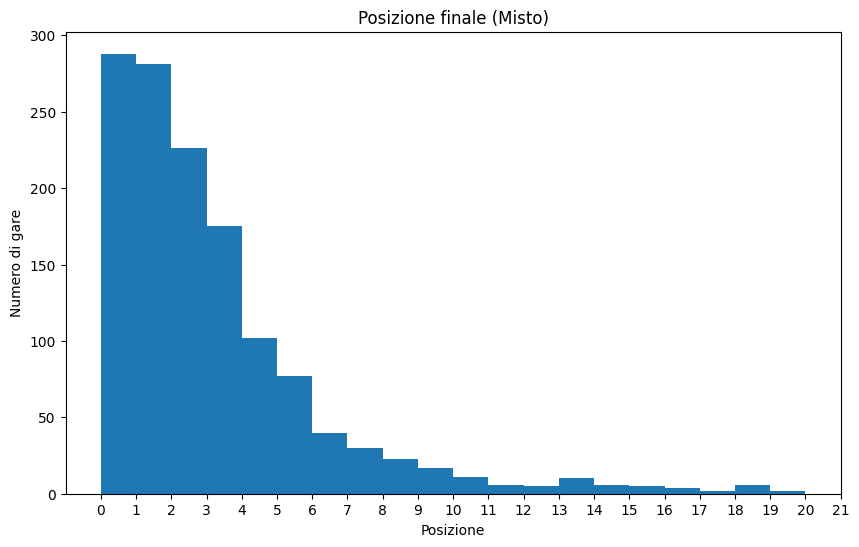

In [15]:
position_misto = df[df["tipo_circuito"] == "Misto"]
plt.figure(figsize=(10, 6))
plt.hist(position_misto["posizione_finale"].astype(int), bins=20)
plt.xlabel("Posizione") 
plt.ylabel("Numero di gare")
plt.xticks(range(0, 22))
plt.title("Posizione finale (Misto)")

plt.show()

Adesso visualizziamo i dati tramite dei boxplot per ogni tipo di circuito per evidenziare la mediana delle posizioni dei piloti in base al tipo di circuito

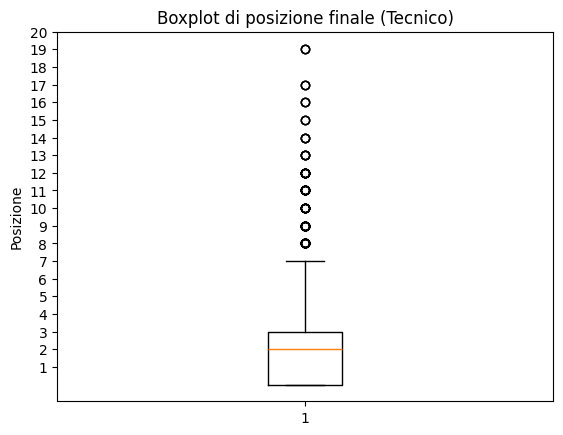

In [16]:
plt.boxplot(position_technical["posizione_finale"].astype(int))
plt.yticks(range(1, 21))
plt.ylabel("Posizione")
plt.title("Boxplot di posizione finale (Tecnico)")
plt.show()

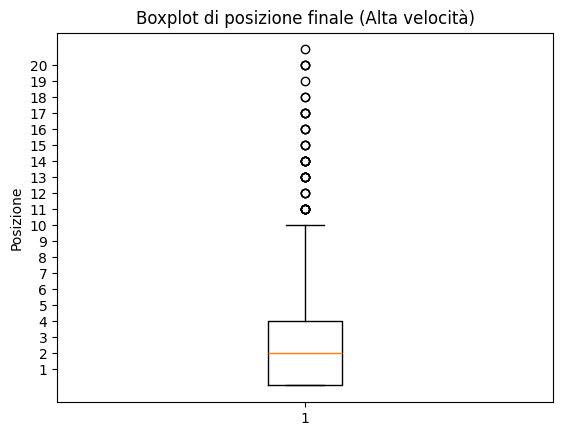

In [17]:
plt.boxplot(position_highspeed["posizione_finale"].astype(int))
plt.yticks(range(1, 21))
plt.ylabel("Posizione")
plt.title("Boxplot di posizione finale (Alta velocità)")
plt.show()

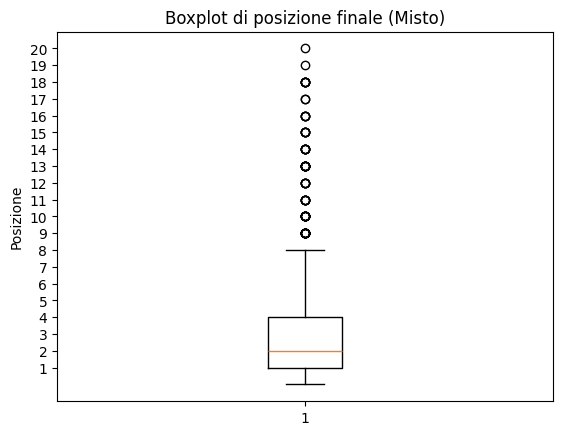

In [18]:
plt.boxplot(position_misto["posizione_finale"].astype(int))
plt.yticks(range(1, 21))
plt.ylabel("Posizione")
plt.title("Boxplot di posizione finale (Misto)")
plt.show()

## OLAP

Creiamo una OLAP per visualizzare in modo alternativo le informazioni dei piloti in base al tipo di circuito. Una volta creato l'OLAP possiamo fare slicing per poter osservare più chiaramente i dati.

In [20]:
placements = ["Podio", "Punti", "No punti", "Non arrivato"]
types = ["Tecnico", "Misto", "Alta velocità"]
grid = [1,2,3,4]

OLAP = np.zeros((4,4,3))
for z in range(0,len(types)):
  df_z = df[df['tipo_circuito'] == types[z]]
  for j in range(0,len(placements)):
    for i in range(0,len(grid)):
      OLAP[i,j,z] = np.sum((df_z['posizione_partenza'] == grid[i]) & (df_z['punti'] == placements[j]))

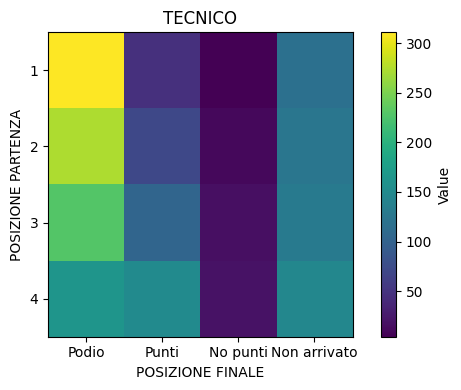

In [22]:
technical = OLAP[:,:,0]

plt.figure(figsize=(6,4))
plt.title('TECNICO')
plt.ylabel('POSIZIONE PARTENZA')
plt.yticks([0,1,2,3], ['1', '2', '3', '4'])
plt.xlabel('POSIZIONE FINALE')
plt.xticks([0,1,2,3], ['Podio', 'Punti', 'No punti', 'Non arrivato'])
plt.imshow(technical)
plt.colorbar(label = "Value")

plt.tight_layout()
plt.show()


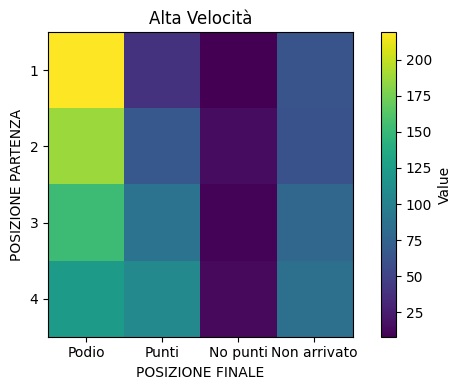

In [23]:
highspeed = OLAP[:,:,1]

plt.figure(figsize=(6,4))
plt.title('Alta Velocità')
plt.ylabel('POSIZIONE PARTENZA')
plt.yticks([0,1,2,3], ['1', '2', '3', '4'])
plt.xlabel('POSIZIONE FINALE')
plt.xticks([0,1,2,3], ['Podio', 'Punti', 'No punti', 'Non arrivato'])
plt.imshow(highspeed)
plt.colorbar(label = "Value")

plt.tight_layout()
plt.show()


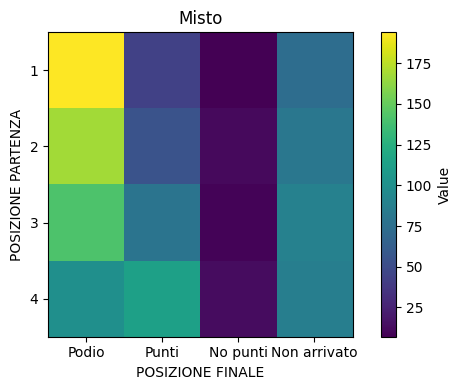

In [24]:
misto = OLAP[:,:,2]

plt.figure(figsize=(6,4))
plt.title('Misto')
plt.ylabel('POSIZIONE PARTENZA')
plt.yticks([0,1,2,3], ['1', '2', '3', '4'])
plt.xlabel('POSIZIONE FINALE')
plt.xticks([0,1,2,3], ['Podio', 'Punti', 'No punti', 'Non arrivato'])
plt.imshow(misto)
plt.colorbar(label = "Value")

plt.tight_layout()
plt.show()

Possiamo anche calcolare una percentuale rispetto all'arrivo sul podio e alla posizione di partenza.

In [30]:
for i in range(0, len(grid)):
  df_i = df[df['posizione_partenza'] == grid[i]]
  df_i = df_i[df_i['punti'] == 'Podio']
  print("Posizione di partenza: " + str(grid[i]) + " - Percentuale di arrivi sul podio: " + str(int(len(df_i) / len(df[df['posizione_partenza'] == grid[i]]) * 100)) + "%")

Posizione di partenza: 1 - Percentuale di arrivi sul podio: 64%
Posizione di partenza: 2 - Percentuale di arrivi sul podio: 55%
Posizione di partenza: 3 - Percentuale di arrivi sul podio: 46%
Posizione di partenza: 4 - Percentuale di arrivi sul podio: 34%


# Test statistici

Il test statistico che vogliamo condurre consiste nel verificare se la posizione finale media è inferiore per chi parte più avanti. Inoltre valutiamo anche se la differenza tra le posizioni finali tra i piloti che partono in posizione 1 e 2 è inferiore o maggiore rispetto a quella tra i piloti che partono in posizione 3 e 4. Questo ci fa capire se c'è più differenza nella prima linea rispetto alla seconda.

Ipotesi nulla: 
La posizione finale media è inferiore per chi parte più avanti.

Ipotesi alternativa: 
La posizione finale media è maggiore per chi parte più avanti.

Utilizziamo un t-test ad una coda con significatività 0.05.



In [ ]:
# Test statistici

print("\n--- T-Test a Una Coda (Posizione Finale Media per Posizione di Partenza) ---")
print("    Ipotesi: La posizione finale media è INFERIORE per chi parte più avanti.")
print("    (Testiamo se media(Gruppo1) < media(Gruppo2) usando alternative='less')")

# Definisci le coppie da confrontare includendo P4
comparison_pairs = [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]

# Mappatura inversa per leggibilità (opzionale ma utile)
tipo_circuito_map = {0: 'Tecnico', 1: 'Alta velocità', 2: 'Misto'}

# Itera sui tipi di circuito
for tipo_codice, tipo_nome in tipo_circuito_map.items():
    print(f"\n--- Tipo Circuito: {tipo_nome} (Codice: {tipo_codice}) ---")
    df_circuito = df[df['tipo_circuito'] == tipo_nome]

    # Itera sulle coppie di posizioni di partenza da confrontare
    for p_start1, p_start2 in comparison_pairs:
        print(f"\n  Confronto: P{p_start1} vs P{p_start2}")

        # Estrai i dati sulla posizione finale per i due gruppi
        group1_pos_finale = df_circuito[df_circuito['posizione_partenza'] == p_start1]['posizione_finale'].dropna()
        group2_pos_finale = df_circuito[df_circuito['posizione_partenza'] == p_start2]['posizione_finale'].dropna()

        # Controlla se ci sono abbastanza dati in entrambi i gruppi
        if len(group1_pos_finale) > 1 and len(group2_pos_finale) > 1:
            # Esegui il t-test di Welch (equal_var=False) a una coda ('less')
            t_stat, p_value = stats.ttest_ind(
                group1_pos_finale,
                group2_pos_finale,
                equal_var=False,       # Usa Welch's t-test
                alternative='less',    # Testa se media(group1) < media(group2)
                nan_policy='omit'      # Ignora NaN (anche se abbiamo già usato dropna)
            )

            print(f"    Media Pos. Finale P{p_start1}: {group1_pos_finale.mean():.2f} (N={len(group1_pos_finale)})")
            print(f"    Media Pos. Finale P{p_start2}: {group2_pos_finale.mean():.2f} (N={len(group2_pos_finale)})")
            print(f"    T-statistic:              {t_stat:.4f}")
            print(f"    P-value (one-tailed):     {p_value:.4f}")

            # Interpretazione del p-value
            if p_value < 0.05:
                print(f"    -> Differenza statisticamente significativa (p < 0.05).")
                print(f"       La posizione finale media per P{p_start1} è significativamente inferiore a quella per P{p_start2}.")
            else:
                print(f"    -> Differenza non statisticamente significativa (p >= 0.05).")
        else:
            print(f"    Non abbastanza dati per eseguire il t-test tra P{p_start1} (N={len(group1_pos_finale)}) e P{p_start2} (N={len(group2_pos_finale)}).")
    # Dizionario per memorizzare le medie calcolate per questo tipo di circuito
    medie_posizioni = {}

    # Esegui i t-test (o semplicemente calcola le medie se non servono più i test)
    for p_start in [1, 2, 3, 4]:
        pos_finale_group = df_circuito[df_circuito['posizione_partenza'] == p_start]['posizione_finale'].dropna()
        if len(pos_finale_group) > 0:
            medie_posizioni[p_start] = pos_finale_group.mean()
        else:
            medie_posizioni[p_start] = None # O un altro placeholder come np.nan

    # --- NUOVO: Calcolo e confronto differenze tra file ---
    print(f"\n  Confronto Differenze Medie tra File (Tipo: {tipo_nome}):")

    diff_fila1 = None
    if medie_posizioni.get(1) is not None and medie_posizioni.get(2) is not None:
        diff_fila1 = abs(medie_posizioni[1] - medie_posizioni[2])
        print(f"    Differenza Media Fila 1 (P1 vs P2): {diff_fila1:.2f} (Basata su medie {medie_posizioni[1]:.2f} e {medie_posizioni[2]:.2f})")
    else:
        print("    Differenza Media Fila 1 (P1 vs P2): Dati insufficienti.")

    diff_fila2 = None
    if medie_posizioni.get(3) is not None and medie_posizioni.get(4) is not None:
        diff_fila2 = abs(medie_posizioni[3] - medie_posizioni[4])
        print(f"    Differenza Media Fila 2 (P3 vs P4): {diff_fila2:.2f} (Basata su medie {medie_posizioni[3]:.2f} e {medie_posizioni[4]:.2f})")
    else:
        print("    Differenza Media Fila 2 (P3 vs P4): Dati insufficienti.")

    # Confronto descrittivo
    if diff_fila1 is not None and diff_fila2 is not None:
        if abs(diff_fila1 - diff_fila2) < 0.1: # Tolleranza piccola per definire "simili"
            print("    -> Le differenze medie tra le file sono molto simili.")
        elif diff_fila1 > diff_fila2:
            print("    -> La differenza media tra P1 e P2 è MAGGIORE di quella tra P3 e P4.")
        else:
            print("    -> La differenza media tra P3 e P4 è MAGGIORE di quella tra P1 e P2.")


--- T-Test a Una Coda (Posizione Finale Media per Posizione di Partenza) ---
    Ipotesi: La posizione finale media è INFERIORE per chi parte più avanti.
    (Testiamo se media(Gruppo1) < media(Gruppo2) usando alternative='less')

--- Tipo Circuito: Tecnico (Codice: 0) ---

  Confronto: P1 vs P2
    Media Pos. Finale P1: 1.56 (N=478)
    Media Pos. Finale P2: 2.14 (N=478)
    T-statistic:              -3.8641
    P-value (one-tailed):     0.0001
    -> Differenza statisticamente significativa (p < 0.05).
       La posizione finale media per P1 è significativamente inferiore a quella per P2.

  Confronto: P1 vs P3
    Media Pos. Finale P1: 1.56 (N=478)
    Media Pos. Finale P3: 2.67 (N=480)
    T-statistic:              -6.7906
    P-value (one-tailed):     0.0000
    -> Differenza statisticamente significativa (p < 0.05).
       La posizione finale media per P1 è significativamente inferiore a quella per P3.

  Confronto: P1 vs P4
    Media Pos. Finale P1: 1.56 (N=478)
    Media Pos. 

# Regressione Lineare

Vogliamo creare un modello predittivo con l'algoritmo di regressione lineare che data la posizione di partenza, il tipo di circuito e il tempo del primo giro, possa prevedere la posizione finale del pilota in gara.

Per farlo, dobbiamo creare un dataframe che abbia: posizione di partenza, posizione in classifica del pilota pre-gara, tipo di circuito e posizione finale.

In [ ]:
# Caricamento dei dati
driver_standings = pd.read_csv("f1db-csv/f1db-races-driver-standings.csv")

# 1. Unire races e circuits per ottenere il tipo di circuito per ogni gara
races_circuits = pd.merge(races, circuits[['circuitId', 'circuitType']], 
                         on='circuitId', how='left')

# 2. Preparare le Classifiche per il Merge "Pre-Gara"
#    Unisci standings con races per avere anno e round della classifica
driver_standings_info = pd.merge(driver_standings[['raceId', 'driverId', 'points', 'positionDisplayOrder']],
                                 races[['raceId', 'year', 'round']],
                                 on='raceId', how='left')

#    Rinomina la colonna 'position' per chiarezza (questa è la pos *dopo* la gara)
driver_standings_info = driver_standings_info.rename(columns={'positionDisplayOrder': 'classifica_post_gara'})

#    Crea la colonna chiave per il merge: il round a cui questa classifica si applicherà come "pre-gara"
driver_standings_info['round_per_merge'] = driver_standings_info['round'] + 1

#    Seleziona le colonne necessarie per il merge successivo
standings_per_merge = driver_standings_info[[
    'driverId', 'year', 'round_per_merge', 'classifica_post_gara'
]]


# 3. Unire Risultati con Informazioni Gare/Circuiti
results_with_race_info = pd.merge(results[['raceId', 'driverId', 'constructorId', 'gridPositionNumber', 'positionNumber', 'points', 'laps']],
                                  races_circuits[['raceId', 'year', 'round', 'circuitType_y']],
                                  on='raceId', how='left')

# 4. Unire i Risultati con le Classifiche PRE-GARA
#    Usiamo 'left' merge per mantenere tutti i risultati di gara
#    Colleghiamo la gara corrente (year, round) con la classifica calcolata per il round precedente (year, round_per_merge)
final_df = pd.merge(
    results_with_race_info,
    standings_per_merge,
    left_on=['driverId', 'year', 'round'],
    right_on=['driverId', 'year', 'round_per_merge'],
    how='left'
)

#    Rinominiamo la colonna della classifica ottenuta (che è quella pre-gara)
final_df = final_df.rename(columns={'classifica_post_gara': 'classifica_pre_gara'})


# 5. Pulizia e Selezione Finale

#    Filtra via le gare del primo round (non hanno classifica pre-gara nella stagione)
#    Oppure puoi gestire i NaN in 'classifica_pre_gara' in altro modo se preferisci
f1_analysis_df = final_df[final_df['round'] != 1].copy() # Usiamo .copy() per evitare SettingWithCopyWarning

#    Seleziona e rinomina le colonne finali
f1_analysis_df = f1_analysis_df[['gridPositionNumber', 'classifica_pre_gara', 'circuitType_y', 'positionNumber']]
f1_analysis_df = f1_analysis_df.rename(columns={
    'gridPositionNumber': 'posizione_partenza',
    'classifica_pre_gara': 'classifica_pre_gara_rank', # Rinominato per chiarezza
    'circuitType_y': 'tipo_circuito',
    'positionNumber': 'posizione_finale'
})

#    Gestisci valori mancanti (se ce ne sono ancora dopo il filtro round 1)
#    Potrebbero mancare classifiche per piloti entrati a stagione in corso nel loro primo GP
f1_analysis_df = f1_analysis_df.dropna(subset=['posizione_partenza', 'posizione_finale', 'classifica_pre_gara_rank'])

#    Converti tipi di dato
#    Assicurati che le posizioni siano numeriche (potrebbero esserci ritiri codificati come testo in 'positionOrder')
#    Potrebbe essere necessario convertire prima in numerico, gestendo errori
f1_analysis_df['posizione_finale'] = pd.to_numeric(f1_analysis_df['posizione_finale'], errors='coerce')
f1_analysis_df = f1_analysis_df.dropna(subset=['posizione_finale']) # Rimuovi eventuali righe non convertibili

f1_analysis_df['posizione_partenza'] = f1_analysis_df['posizione_partenza'].astype(int)
f1_analysis_df['posizione_finale'] = f1_analysis_df['posizione_finale'].astype(int)
f1_analysis_df['classifica_pre_gara_rank'] = f1_analysis_df['classifica_pre_gara_rank'].astype(int)

#    Codifica 'tipo_circuito' (come avevi già fatto)
f1_analysis_df['tipo_circuito'] = np.where(
    f1_analysis_df['tipo_circuito'] == 'Tecnico', 0,
    np.where(f1_analysis_df['tipo_circuito'] == 'Alta velocità', 1, 2) # Assumendo 2 per 'Misto'
)
f1_analysis_df['tipo_circuito'] = f1_analysis_df['tipo_circuito'].astype(int)

#    Reset index se vuoi un indice pulito
f1_analysis_df = f1_analysis_df.reset_index(drop=True)

# --- Visualizzazione ---
f1_analysis_df.head()






,posizione_partenza,classifica_pre_gara_rank,tipo_circuito,posizione_finale
0,2,1,0,1
1,3,4,0,2
2,10,13,0,3
3,8,14,0,4
4,16,8,0,9


### Allenamento del modello
Ora che abbiamo creato il dataframe necessario per il modello di regressione lineare, dividiamo i dati in training e validation set utilizzando la funzione train_test_split.

In [ ]:
from sklearn.model_selection import train_test_split


feature = ["posizione_partenza", "classifica_pre_gara_rank", "tipo_circuito"]

# I dati in input sono posizione di partenza, tempo del primo giro e tipo di circuito
X = f1_analysis_df[feature]

# I dati in output sono la posizione finale
y = f1_analysis_df["posizione_finale"]

# Facciamo il train test split usando il 20% come test set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)



Adesso che abbiamo preparato i dati dividendo il dataset in train e validation set, possiamo allenare il modello.

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# Alleniamo sul dataset di training
model.fit(X_train, y_train)

# Facciamo le predizioni
y_pred = model.predict(X_valid)

### Correttezza
Verfichiamo adesso la correttezza del modello confrontando gli errori medi con quelli del modello null

In [ ]:
from sklearn import metrics

print("------Modello LinearRegression------")
print("MAE:",metrics.mean_absolute_error(y_pred,y_valid))
print("MSE:",metrics.mean_squared_error(y_pred,y_valid))
print("RMSE:",metrics.root_mean_squared_error(y_pred,y_valid))

------Modello LinearRegression------
MAE: 2.5489902803381006
MSE: 10.911060688678146
RMSE: 3.303189472112998


In [ ]:
#calcolate lo score medio
mean_score = np.mean(y_train)
null_model_y = np.ones(len(y_valid)) * mean_score

print("------Null Model------")
print("MAE:",metrics.mean_absolute_error(null_model_y,y_valid))
print("MSE:",metrics.mean_squared_error(null_model_y,y_valid))
print("RMSE:",metrics.root_mean_squared_error(null_model_y,y_valid))

------Null Model------
MAE: 4.218855744567175
MSE: 24.93159192211981
RMSE: 4.9931545061333535
